# ELEC 221 Assignment 6: radio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, Image
from IPython.core.display import HTML
from scipy import signal

In this problem, you'll implement a simulated AM radio system that is a little more realistic in terms of the operation of the receiver and demodulation process.

Suppose you and your colleague have been put in charge of a radio broadcast company that manages 5 stations at the following frequencies (in kHz): 580, 600, 620, 640, and 660. Note that typically, AM is used for talk radio, which requires a bandwidth of ~10 kHz. However to make things interesting, we're going to use music which requires a wider range.

**Question 0.1 (1 point)**. To make things more meaningful for you (hopefully!), choose five songs, perhaps of different genres, for your radio stations. Select ~4-5s clips of each, and use a sampling rate of somewhere between 40000-48000.

In [ ]:
# Prepare some samples and load them in here.
# input_audio = wavfile.read("my_song.wav")

# The result of importing a wavfile should be a tuple of two elements:
# the sample rate, and the audio signal, which may be have multiple channels.
# sample_rate = input_audio[0]

# My audio sample had multiple channels. Yours may not.
# In my case, I took just one of these channels, and converted it from
# integer values to floats.
# channel_0 = input_audio[1][:, 0]
# song_1 = np.array(channel_0, dtype=np.float64) / np.max(channel_0)

In [ ]:
# The Great War
input_audio_1 = wavfile.read("The_Great_War.wav")
sample_rate_1 = input_audio_1[0]
channel_0_1 = input_audio_1[1][:, 0]
song_1 = np.array(channel_0_1, dtype=np.float64) / np.max(channel_0_1)

# Cigarette Daydreams
input_audio_2 = wavfile.read("Cigarette_Daydreams.wav")
sample_rate_2 = input_audio_2[0]
channel_0_2 = input_audio_2[1][:, 0]
song_2 = np.array(channel_0_2, dtype=np.float64) / np.max(channel_0_2)

# Mr. Brightside
input_audio_3 = wavfile.read("Mr._Brightside.wav")
sample_rate_3 = input_audio_3[0]
channel_0_3 = input_audio_3[1][:, 0]
song_3 = np.array(channel_0_3, dtype=np.float64) / np.max(channel_0_3)

# Silver Lining
input_audio_4 = wavfile.read("Silver_Lining.wav")
sample_rate_4 = input_audio_4[0]
channel_0_4 = input_audio_4[1][:, 0]
song_4 = np.array(channel_0_4, dtype=np.float64) / np.max(channel_0_4)

# Wish I Knew You
input_audio_5 = wavfile.read("Wish_I_Knew_You.wav")
sample_rate_5 = input_audio_5[0]
channel_0_5 = input_audio_5[1][:, 0]
song_5 = np.array(channel_0_5, dtype=np.float64) / np.max(channel_0_5)

Audio(song_1, rate=sample_rate_1)

In [ ]:
# cutting down the songs so they are all the same length
# the shortest song is Wish I Knew You (song_5)

N = len(song_5)
song_1 = song_1[0 : N]
song_2 = song_2[0 : N]
song_3 = song_3[0 : N]
song_4 = song_4[0 : N]

# all songs have the same sample rate (48 000) so we can initialize a new sample_rate variable that we will use for each song
sample_rate = sample_rate_1

Audio(song_2, rate=sample_rate)

## Part 1. The broadcast

We will begin by setting up the broadcast process according to the following block diagram:

<img src="broadcast.png" width=700>

We'll do this in a couple different steps.

**Question 1.1 (1 point)**. First, design a lowpass filter to reduce the bandwidth of a signal to within the acceptable range of our radio stations.

In [ ]:
def reduce_signal_bandwidth(signal, sample_rate):
    """Reduce the bandwidth of a signal to within a ~20 kHz band.

    Here, 20 kHz corresponds to the space a signal will take when considering
    both positive and negative frequencies, like we have seen during the
    amplitude modulation lectures in class.

    It is up to you to decide how to filter it. You may choose to use an
    ideal brick wall filter, or a more realistic non-ideal filter (it doesn't
    need to be exactly 20 kHz wide, just something appropriate for the
    application).

    Args:
        signal (array[float]): A real-valued signal.
        sample_rate (int): the sample rate of the signal

    Returns:
        array[float]: A signal that has been filtered so that its spectrum is
        band-limited.
    """

    fourier_coefficients = np.fft.rfft(signal, norm="forward")
    frequencies =  np.fft.rfftfreq(len(signal), 1 / sample_rate)

    output = []

    for i in range (0, len(frequencies)):
      if abs(frequencies[i]) < 10000:
        output.append(fourier_coefficients[i])
      else:
        output.append(0)

    output_signal = np.fft.irfft(output)

    return np.array(output_signal)

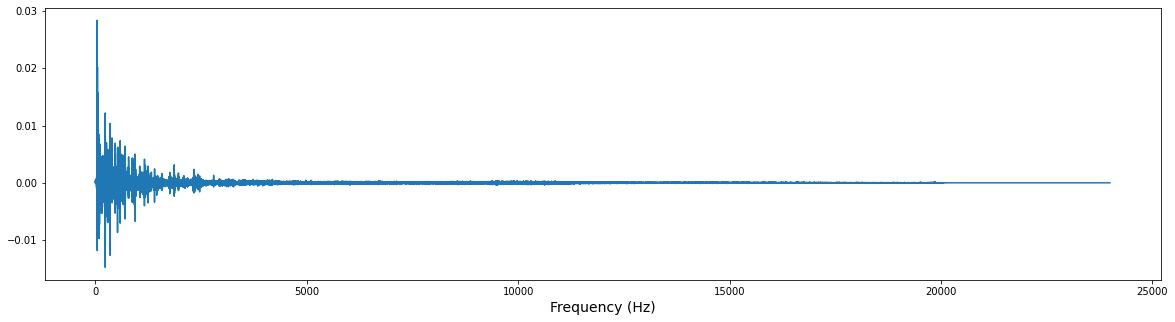

In [ ]:
fourier_coefficients = np.fft.rfft(song_1, norm="forward")
frequency_spectrum =  np.fft.rfftfreq(len(song_1), 1 / sample_rate)
plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, fourier_coefficients.real)
plt.xlabel("Frequency (Hz)", fontsize=14)

Audio(song_1, rate=sample_rate_1)

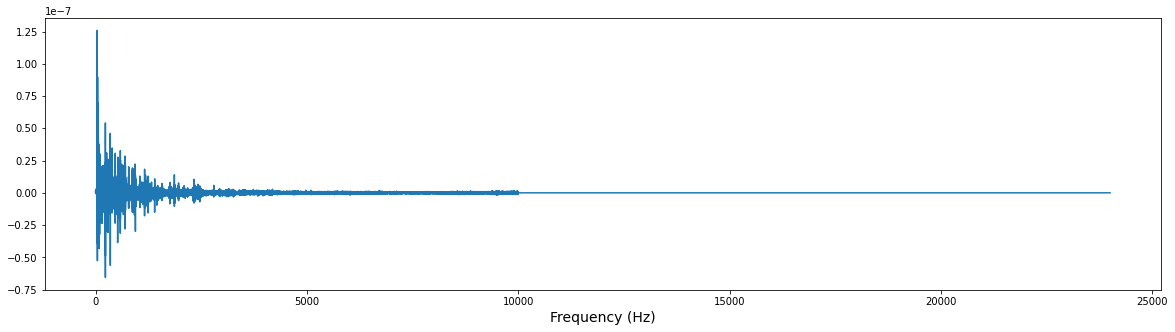

In [ ]:
song_1_reduced = reduce_signal_bandwidth(song_1, sample_rate)

fourier_coefficients = np.fft.rfft(song_1_reduced, norm="forward")
frequency_spectrum =  np.fft.rfftfreq(len(song_1_reduced), 1 / sample_rate)

plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, fourier_coefficients.real)
plt.xlabel("Frequency (Hz)", fontsize=14)

Audio(song_1_reduced, rate=sample_rate)

**Question 1.2 (1 point)** Implement a function that performs sinusoidal amplitude modulation (with a $\cos$ carrier signal) of a signal into the frequency range of a desired radio station.

In [ ]:
def sinusoidal_amplitude_modulation(signal, sample_rate, station_frequency, phase=0.0):
    """Modulate a signal up to the frequency of a desired AM radio station.

    The amplitude modulation should have the form:
       y(t) = x(t) * c(t) = x(t) * cos(2 * π * f_c * t + θ_c)
    where f_c is the carrier (station) frequency, and θ_c is a phase.

    Args:
        song (array[float]): A real-valued signal.
        time_range (array[float]): The explicit times over which the signal is defined.
        station_frequency (int): The (carrier) frequency of the station, in kHz.
        phase (float): The phase of the carrier signal.

    Returns:
        array[float]: The modulated signal.
    """
    time_length = len(signal)/sample_rate
    time_range = np.linspace(0, time_length, len(signal))
    carrier_signal = []
    for t in time_range:
      carrier_signal.append(np.cos(2 * np.pi * station_frequency * t + phase))
    modulated_signal = np.array(carrier_signal)*signal

    return modulated_signal

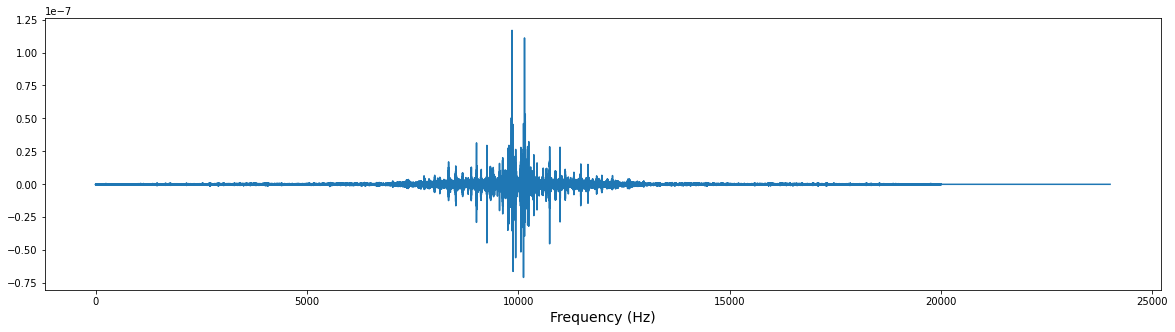

In [ ]:
song_2_reduced = reduce_signal_bandwidth(song_2, sample_rate)

# plotting the AM modulation function
AM_signal = sinusoidal_amplitude_modulation(song_2_reduced,sample_rate,10000)

fourier_coefficients = np.fft.rfft(AM_signal, norm="forward")
frequency_spectrum =  np.fft.rfftfreq(len(AM_signal), 1 / (sample_rate))

plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, fourier_coefficients.real)
plt.xlabel("Frequency (Hz)", fontsize=14)

Audio(AM_signal, rate=sample_rate)

**Question 1.3 (1 point)**. Your radio company will use frequency-division multiplexing (FDM) to send multiple signals over the same channel. Using the frequencies listed above, implement a broadcast (transmission) system that takes a set of signals as input, and outputs the full radio broadcast.

In [ ]:
def broadcast(signals, sample_rate):
    """Broadcast a set of signals at different frequencies to simulate
    a set of radio stations.

    This function should:
      - reduce the bandwidth of each of the provided signals
      - modulate each one to the correct frequency range
      - perform FDM to generate a combined output signal to be broadcast

    Args:
        signals (list[array[float]]): A list of signals to be transmitted.
             Assume that they are provided in order of increasing station frequency.

    Returns:
        array[float]: A single channel contain the frequency-division multiplexed
        set of signals.
    """
    broadcast_signals = []

    for i in range(0,len(signals)):
      # reduce bandwidth
      reduced_signal = reduce_signal_bandwidth(signals[i],sample_rate)

      # upsample signal
      upsample_factor = 30
      upsampled = signal.resample(reduced_signal, upsample_factor*len(reduced_signal))

      # modulate signal
      # station frequencies set to 0,20k,40k,60k,80k
      mod_signal = sinusoidal_amplitude_modulation(upsampled,upsample_factor*sample_rate,(580+20*i)*1000)

      broadcast_signals.extend(mod_signal)

    # convert to time domain
    output = (broadcast_signals)

    return np.array(output)

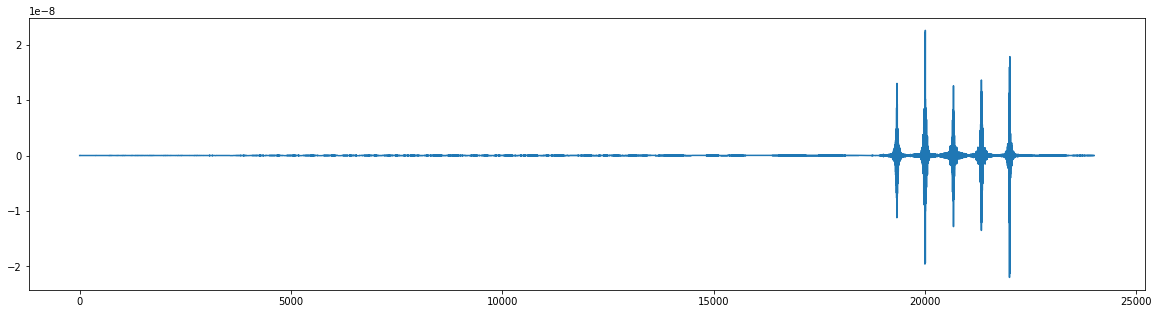

In [ ]:
# testing function
station_signals = [song_1,song_2,song_3,song_4,song_5]

stations = broadcast(station_signals,sample_rate)

fourier_coefficients = np.fft.rfft(stations, norm="forward")
frequency_spectrum =  np.fft.rfftfreq(len(stations), 1 / sample_rate)

plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, fourier_coefficients.real)

## Part 2. A simple receiver

In order to test your broadcasting setup, let's implement a simple synchronous demodulation system.

**Question 2.1 (1 point)** Complete the function below to implement the synchronous demodulation system that we described in class (see the docstring below for details).

In [ ]:
def simple_receiver(broadcast, station_frequency, sample_rate, phase=0.0, bandpass=True):
    """Demodulate the radio broadcast and extract a desired station.

    This function should:
      - apply a bandpass filter (if specified) to the signal to extract
        only the parts of the spectrum in the desired station's frequency range
      - demodulate with a sinusoidal carrier (use cos) at the desired frequency
      - apply a low-pass filter with the appropriate gain to recover the signal

    Args:
        broadcast (array[float]): A radio broadcast consisting of five channels
            that have been FD multiplexed.
        station_frequency (int): The frequency (in kHz) of the radio station.
        sample_rate(int): The sample rate of the broadcast signals.
        phase (float): The phase of the demodulating signal.
        bandpass (bool): Whether or not to apply a bandpass filter before
            demodulating and filtering.

    Returns:
        array[float]: The signal of the radio station at the desired frequency.
    """
    # upsample the signal to ensure no aliasing occurs
    # the highest frequency is 80k so the sampling rate should be at least 160k. A sample factor of at least 4 assures this.
    upsample_factor = 30

    # find the lower and upper bounds for the station frequencies
    lower_bound = (station_frequency*1000-10000)/upsample_factor
    upper_bound = (station_frequency*1000+10000)/upsample_factor

    # convert to frequency domain
    fourier_coefficients = np.fft.rfft(stations, norm="forward")
    frequencies =  np.fft.rfftfreq(len(stations), 1 / sample_rate)

    bandpass_freq = []

    # apply bandpass filter
    if bandpass:
      for i in range (0, len(frequencies)):
        if abs(frequencies[i]) > lower_bound and abs(frequencies[i]) < upper_bound:
          bandpass_freq.append(fourier_coefficients[i])
        else:
          bandpass_freq.append(0)
      bandpassed = np.array(np.fft.irfft(bandpass_freq))
    else:
      bandpassed = np.array(fourier_coefficients)

    # demodulate signal and apply gain of 2
    modulated_signal = sinusoidal_amplitude_modulation(2*bandpassed,sample_rate*upsample_factor,station_frequency*1000,phase=phase)

    # convert to frequency domain
    fourier_coefficients = np.fft.rfft(modulated_signal, norm="forward")
    frequencies =  np.fft.rfftfreq(len(modulated_signal), 1 / sample_rate)

    lowpass_freq = []

    # apply lowpass filter with and cutoff frequency at station frequency
    for i in range (0, len(frequencies)):
      if abs(frequencies[i]) < (10000/upsample_factor):
        lowpass_freq.append(fourier_coefficients[i])
      else:
        lowpass_freq.append(0)

    # convert to time domain
    lowpass_output = np.array(np.fft.irfft(lowpass_freq))

    # downsample by the lowpass filter output by the same factor as the upsample_factor to retrieve original signal
    decimated = signal.decimate(lowpass_output, upsample_factor)

    # chop down song
    # length = len(decimated)
    # number_of_songs = 5
    # song_num = int((station_frequency-580)/20)
    # orig_length = int(length/number_of_songs)
    # chopped = decimated[orig_length * song_num : orig_length * song_num + orig_length]

    return decimated

**Question 2.2 (0.5 point)**. Test your demodulation function below to extract the 600 kHz station.

In [ ]:
song_2_retrieved = simple_receiver(stations, 600, sample_rate)
Audio(song_2_retrieved, rate=sample_rate)

**Question 2.3 (0.5 point)**. Test your demodulation function with a non-zero phase; what happens to the output signal when the modulation and demodulation are not perfectly in sync?

In [ ]:
song_2_phase_change = simple_receiver(stations, 600, sample_rate, phase=np.pi/3)
Audio(song_2_phase_change, rate=sample_rate)

It delays when the song plays by a set amount.

**Question 2.4 (0.5 point)**. Set `bandpass=False` and test the demodulation; how does it sound?

In [ ]:
song_2_no_bandpass = simple_receiver(stations, 600, sample_rate, bandpass=False)
Audio(song_2_no_bandpass, rate=sample_rate)

/usr/local/lib/python3.8/dist-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


We get some noise that is not filtered out.

**Question 2.5 (0.5 point)**. Try demodulating with an invalid station frequency (e.g., 590, 610, anything that sits in between our allotted values). Does this sound like you expect?

In [ ]:
song_2_and_3 = simple_receiver(stations, 610, sample_rate)
Audio(song_2_and_3, rate=sample_rate)

We are getting weird noise. This makes sense as we aren't getting the full frequency spectrum for either song, so what we are getting is a mix of some of their frequencies which comes out as noise.

## Part 3: the superheterodyne receiver

In practice, AM radio is demultiplexed and demodulated by a system called the [superheterodyne receiver](https://en.wikipedia.org/wiki/Superheterodyne_receiver) (or superhet for short). Consider the (simplified) diagram below (there should in principle be some amplifiers in here, but we will ignore them):

<img src="superhet.png" width="800">

Here, $y(t)$ corresponds to the multiplexed signal that your broadcast outputs. This is put through a coarse tunable bandpass filter (this corresponds to you turning the radio dial), then mixed with a variable-frequency local oscillator to produce a signal centered at an intermediate frequency (IF) of 455 kHz. Said signal is then put through a fixed bandpass filter before being sent to the demodulator.

**Question 3.0 (0.5 point)**: Why do you think this kind of setup is used; why not just use a simple tunable filter from the get go? (You may need to do a little research on the history of the development of radio.)

Because sometimes you wanna make sure the frequency gets shifted to a region that is easy to play around with. This makes it easier to tune and the filters tend to work better at a lower frequency.

**Question 3.1 (1 point)**: Implement the heterodyning process in the the graphic above. The function should take the multiplexed signal as input and a desired radio station frequency, and output the demodulated audio signal.

In [ ]:
def superhet_receiver(radio_broadcast, station_frequency):
    """Implement a simplified superheterodyne receiver to extract a desired station.

    This function should:
      - apply a bandpass filter to the signal to extract the correct
        frequency regime
      - use a local oscillator (frequency related to the bandpass) to yield an
        intermediate frequency signal at 455 kHz
      - apply a fixed bandpass filter and then demodulate to recover the station

    Args:
        broadcast (array[float]): A radio broadcast consisting of five channels
            that have been FD multiplexed.
        station_frequency (int): The frequency (in kHz) of the radio station.

    Returns:
        array[float]: The signal of the radio station at the desired frequency.
    """
    # define the upsample rate (Needs to be 930 with initial sample rate of 192)
    upsample_factor = 30

    # find the lower and upper bounds for the station frequencies
    lower_bound = (station_frequency*1000-10000)/upsample_factor
    upper_bound = (station_frequency*1000+10000)/upsample_factor

    # convert to frequency domain
    fourier_coefficients = np.fft.rfft(radio_broadcast, norm="forward")
    frequencies =  np.fft.rfftfreq(len(radio_broadcast), 1 / sample_rate)

    bandpass_freq = []

    # apply a bandpass filter centered about the station frequency
    for i in range (0, len(frequencies)):
      if abs(frequencies[i]) > lower_bound and abs(frequencies[i]) < upper_bound:
        bandpass_freq.append(fourier_coefficients[i])
      else:
        bandpass_freq.append(0)
    bandpass = np.array(np.fft.irfft(bandpass_freq))

    # modulate signal to 455kHz
    modulated_to_zero = sinusoidal_amplitude_modulation(2*bandpass,sample_rate*upsample_factor,station_frequency*1000)
    modulated_signal = sinusoidal_amplitude_modulation(2*modulated_to_zero,sample_rate*upsample_factor,455*1000)

    # convert to frequency domain
    fourier_coefficients2 = np.fft.rfft(modulated_signal, norm="forward")
    frequencies2 =  np.fft.rfftfreq(len(modulated_signal), 1 / sample_rate)

    bandpass2_freq = []

    # apply another bandpass filter
    for i in range (0, len(frequencies2)):
      if abs(frequencies2[i]) > 445*1000 and abs(frequencies2[i]) < 465*1000:
        bandpass2_freq.append(fourier_coefficients2[i])
      else:
        bandpass2_freq.append(0)
    bandpass2 = np.array(np.fft.irfft(bandpass2_freq))

    # demodulate signal and apply gain of 4
    demodulated_signal = sinusoidal_amplitude_modulation(2*bandpass2,sample_rate*upsample_factor,455*1000)

    # downsample by the lowpass filter output by the same factor as the upsample_factor to retrieve original signal
    decimated = signal.decimate(demodulated_signal, upsample_factor)

    return decimated

**Question 3.2 (0.5 point)**: Let's put everything together: below, use the broadcast function to create a signal, and then pass it to the superheterodyne receiver to play your favourite station.

In [ ]:
song_2_superhet = superhet_receiver(stations,600)
Audio(song_2_superhet, rate=sample_rate)